### %load_ext autoreload
%autoreload 2

In [22]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.nn as nn

In [3]:
import sys
sys.path.append('/Users/dmitry/Desktop/Thesis/topics_ds/models')
sys.path.append('/Users/dmitry/Desktop/Thesis/topics_ds/data')
sys.path.append('/Users/dmitry/Desktop/Thesis/topics_ds/pytorch')

In [26]:
from data import data
from pytorch import torch_models, radam

In [5]:
IMG_LEN = 1024
TXT_LEN = 300
N_CLASSES = 50

### Data loading

In [6]:
x_img, x_txt, y = data.get_unpacked_data()

### Stratified train-val-test split

In [7]:
x_img_train, x_img_test, x_txt_train, x_txt_test, y_train, y_test = train_test_split(
    x_img, 
    x_txt, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

x_img_train, x_img_val, x_txt_train, x_txt_val, y_train, y_val = train_test_split(
    x_img_train,
    x_txt_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

### Standard Scaling

In [8]:
img_sscaler = StandardScaler()
img_sscaler.fit(x_img_train)

x_img_train = img_sscaler.transform(x_img_train)
x_img_val = img_sscaler.transform(x_img_val)
x_img_test = img_sscaler.transform(x_img_test)

txt_sscaler = StandardScaler()
txt_sscaler.fit(x_txt_train)

x_txt_train = txt_sscaler.transform(x_txt_train)
x_txt_val = txt_sscaler.transform(x_txt_val)
x_txt_test = txt_sscaler.transform(x_txt_test)

### Convert from numpy arrays to tensors

In [9]:
x_img_train_t = torch.tensor(x_img_train)
x_img_val_t = torch.tensor(x_img_val)
x_img_test_t = torch.tensor(x_img_test)

x_txt_train_t = torch.tensor(x_txt_train)
x_txt_val_t = torch.tensor(x_txt_val)
x_txt_test_t = torch.tensor(x_txt_test)

y_train_t = torch.tensor(y_train)
y_val_t = torch.tensor(y_val)
y_test_t = torch.tensor(y_test)

### Convert to TensorDataset

In [10]:
train_ds = TensorDataset(x_img_train_t, x_txt_train_t, y_train_t)
val_ds = TensorDataset(x_img_val_t, x_txt_val_t, y_val_t)
test_ds = TensorDataset(x_img_test_t, x_txt_test_t, y_test_t)

### Convert to DataLoader

In [11]:
BATCH_SIZE = 1024

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

### Trivial model

In [38]:
trivial_model = torch_models.TrivialModel()

In [39]:
optimizer = optim.Adam(trivial_model.parameters(), lr=0.001)

In [40]:
trivial_writer = SummaryWriter()

In [41]:
EPOCHS = 10
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        trivial_model.zero_grad()
        output = trivial_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = trivial_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    trivial_writer.add_scalar('trivial/accuracy/val', correct/total, epoch)

tensor(1.6595, grad_fn=<NllLossBackward>)
tensor(1.5165, grad_fn=<NllLossBackward>)
tensor(1.4773, grad_fn=<NllLossBackward>)
tensor(1.4376, grad_fn=<NllLossBackward>)
tensor(1.4104, grad_fn=<NllLossBackward>)
tensor(1.3552, grad_fn=<NllLossBackward>)
tensor(1.3528, grad_fn=<NllLossBackward>)
tensor(1.3566, grad_fn=<NllLossBackward>)
tensor(1.3425, grad_fn=<NllLossBackward>)
tensor(1.3599, grad_fn=<NllLossBackward>)


### Regular softmax

In [55]:
norm_model_sm = torch_models.NormModelSM()
optimizer = optim.Adam(norm_model_sm.parameters(), lr=1e-3)
writer = SummaryWriter()

In [56]:
cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')

In [57]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model.zero_grad()
        output = norm_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = cross_entropy_loss(output, torch.argmax(y, dim=1))
        loss.sum().backward()
        optimizer.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    norm_writer.add_scalar('accuracy/val/norm_sm', correct/total, epoch)

### Norm model

In [39]:
norm_model = torch_models.NormModel()
optimizer = optim.Adam(norm_model.parameters(), lr=1e-3)
norm_writer = SummaryWriter('runs/adam')

In [40]:
EPOCHS = 40
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model.zero_grad()
        output = norm_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    norm_writer.add_scalar('train_loss', loss, epoch)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    norm_writer.add_scalar('val_acc', correct/total, epoch)

<function matplotlib.pyplot.show(*args, **kw)>

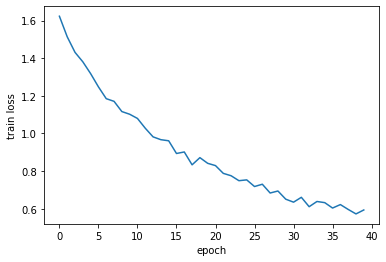

In [24]:
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

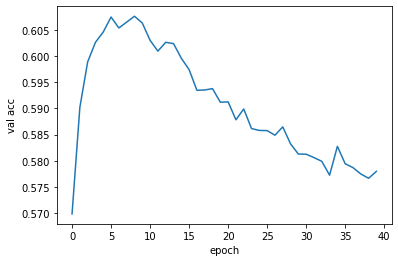

In [25]:
plt.plot(range(len(val_acc_history)), val_acc_history)
plt.xlabel('epoch')
plt.ylabel('val acc')
plt.show

In [22]:
norm_model_4 = torch_models.NormModel()
optimizer = optim.Adam(norm_model_4.parameters(), lr=1e-4)
norm_4_writer = SummaryWriter()

In [23]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_4.zero_grad()
        output = norm_model_4(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_4(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    norm_4_writer.add_scalar('/accuracy/val/norm_4', correct/total, epoch)

In [24]:
norm_model_2 = torch_models.NormModel()
optimizer = optim.Adam(norm_model_2.parameters(), lr=1e-2)
norm_2_writer = SummaryWriter()

In [25]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_2.zero_grad()
        output = norm_model_2(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_2(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    norm_2_writer.add_scalar('accuracy/val/norm_2', correct/total, epoch)

In [28]:
norm_model_s = torch_models.NormModel()
optimizer = optim.Adam(norm_model_s.parameters(), lr=1e-3)
cos_shed = optim.lr_scheduler.CosineAnnealingLR(optimizer, 2000) 
writer = SummaryWriter()

In [29]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_s.zero_grad()
        output = norm_model_s(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
        cos_shed.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_s(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('accuracy/val/norm_s', correct/total, epoch)

In [31]:
norm_model_cs = torch_models.NormModel()
optimizer = optim.Adam(norm_model_cs.parameters(), lr=1e-3)
cyclic_shed = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2, cycle_momentum=False) 
writer = SummaryWriter()

In [32]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_cs.zero_grad()
        output = norm_model_cs(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
        cyclic_shed.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_cs(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('accuracy/val/norm_cs', correct/total, epoch)

In [33]:
with torch.no_grad():
    for x_img, x_txt, y in val_loader:
        output = norm_model_cs(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        for idx, i in enumerate(output):
            if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                correct += 1
            total += 1
            
print(correct/total)

0.5671376011773362


## Rectified ADAM

In [29]:
norm_model_radam = torch_models.NormModel()
optimizer = radam.RAdam(norm_model_radam.parameters())
writer = SummaryWriter('runs/radam')

In [30]:
EPOCHS = 40
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_radam.zero_grad()
        output = norm_model_radam(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    writer.add_scalar('train_loss', loss, epoch)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_radam(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('val_acc', correct/total, epoch)

In [31]:
torch.save({
    'epoch' : 40,
    'model_state_dict' : norm_model_radam.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),    
}, 'saved_models/torch/radam')

## Plain RADAM

In [32]:
norm_model_plain_radam = torch_models.NormModel()
optimizer = radam.PlainRAdam(norm_model_radam.parameters())
writer = SummaryWriter('runs/plain_radam')

In [33]:
EPOCHS = 40
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_plain_radam.zero_grad()
        output = norm_model_plain_radam(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    writer.add_scalar('train_loss', loss, epoch)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_plain_radam(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('val_acc', correct/total, epoch)

In [34]:
torch.save({
    'epoch' : 40,
    'model_state_dict' : norm_model_plain_radam.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),    
}, 'saved_models/torch/radam')

## AdamW

In [35]:
norm_model_adamw = torch_models.NormModel()
optimizer = radam.AdamW(norm_model_adamw.parameters())
writer = SummaryWriter('runs/adamw')

In [36]:
EPOCHS = 40
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_adamw.zero_grad()
        output = norm_model_adamw(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    writer.add_scalar('train_loss', loss, epoch)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_adamw(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('val_acc', correct/total, epoch)

In [37]:
torch.save({
    'epoch' : 40,
    'model_state_dict' : norm_model_adamw.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),    
}, 'saved_models/torch/adamw')